# Continuous Control - DDPG

***Author: Yanxiang Yu***

***Date: April 14th, 2020***

---
We are going to use DDPG algorithm to train an Unity agent- Researcher to reach a moving target with two joints in this notebook.

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

We've 20 identical agents in the enviroment, the task is episodic with 1000 total time steps per episode, after trained with DDPG algorthm for 176 esposides, we reached an average score of 35 for 100 episodes.

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In this notebook, we select the environment with 20 identical agents. 

In [21]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

from workspace_utils import active_session # keep session active


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [22]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
zz = 0 
while True:
    zz += 1
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print('Total steps in one episode: {}'.format(zz))

Total score (averaged over agents) this episode: 0.13349999701604248
Total steps in one episode: 1001


When finished, you can close the environment.

In [7]:
#env.close()

### 4.Train the agents!

Now it's time to train the agent to solve the environment! We are going to use DDPG algorithm to train the agent.

The detail of [DDPG](https://arxiv.org/abs/1509.02971) can be found in the paper by Timothy P. Lillicrap etc.

The DDPG algorithm is an actor-critic, model-free algorithm based on the deterministic policy gradient that can operate over continuous action spaces. The “Actor” updates the policy distribution in the direction suggested by the Critic (such as with policy gradients), and the “Critic” estimates the value function, this could be the action-value (the Q value) or state-value (the V value). During the learning period, both "Actor" and "Critic" have two netowrks- one local network to update the training paramters, and one target network for evaluation of the performance. To update the local network, a soft update is introduced, which use 0.001 of the local network parameters, and 0.999 of the target paramters to update the target network. In addition, to enhance the exploration of the network, Ornstein-Uhlenbeck process is introduces as the noise term added to the actions.

In this agent, we used a 2 hidden layer neural network for both "Actor" and "Critic" network, each layer has 256 and 128 nodes respectively. Other hyperparamters we used are:
* BUFFER_SIZE = int(1e6)  # replay buffer size
* BATCH_SIZE = 128        # minibatch size
* GAMMA = 0.95            # discount factor
* TAU = 1e-3              # for soft update of target parameters
* LR_ACTOR = 1e-4         # learning rate of the actor 
* LR_CRITIC = 1e-3        # learning rate of the critic
* WEIGHT_DECAY = 0        # L2 weight decay
* UPDATE_EVERY = 20       # how often to update the network
* UPDATE_TIMES = 10      # how many times to update the network each time
* EPSILON = 1.0           # epsilon for the noise process added to the actions
* EPSILON_DECAY = 1e-6    # decay for epsilon above

Episode 100	Average Score: 18.36
Episode 176	Average Score: 35.01
Environment solved in 176 episodes.	Average Score: 35.014


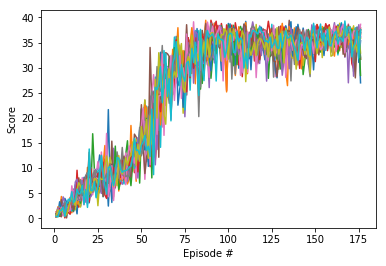

In [8]:
agent = Agent(state_size=33, action_size=4, random_seed=2)
def ddpg(n_episodes=5000, max_t=1000, reset_time=100, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        for t in range(max_t):
        #while True:
            if t % reset_time == 0:
                agent.reset()
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            for i_agent in range(num_agents):
                agent.step(states[i_agent], actions[i_agent], rewards[i_agent], 
                           next_states[i_agent], dones[i_agent])# update the system
            score += rewards                                   # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        # Keep higher threshold during training
        if np.mean(scores_deque) > (35.0):
            print('\nEnvironment solved in {} episodes.\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            break
            
    return scores

with active_session():
    # do long-running work here
    scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
scores100 = []
for i in range(1, 101):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states) # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        #print(scores)
        if np.any(dones):                                  # exit loop if episode finished
            break
    scores100.append(scores)
    
    if i % 10 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores)))

    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), np.mean(scores100))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

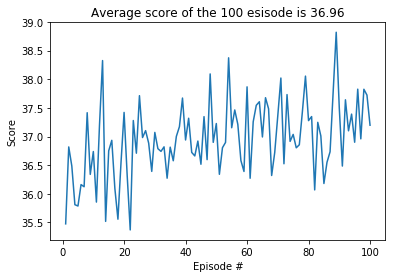

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, 101), np.mean(scores100, axis=1))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Average score of the 100 esisode is 36.96')
plt.show()

In [29]:
print('The average score of 100 epsoides is:',np.mean(scores100))

The average score of 100 epsoides is: 36.955514174


### 5. Summay and Future Work

In this notebook, we used DDPG algorithm to train the Unity agent: Researcher. 20 identical agents were trained in the environment, only 170 epsoides are used to train the agents, and an average score of 36.95 for 100 epsoides is achieved with the trainned agent.

To further improving the agent's performance, we can further training the agent with different hyper-parameters, such as tune the parameters of the network, add dropout layers, change the noise value, batch size, discount factor or update frequency, and so on. In addtion, We can try some other more advanced techniques, including:
* Important sampling: by add importance to the recycled trajactories, and sample them with the probability by their importance
* PPO: proximal Policy Optimization algorithm
* A2C: Advatage Actor Critic algorithm
* GAE: Generalized Advantage Estimation algorithm 

And so on.

Train a single agent in the environment is also worth to try, however, the code would be very similar. 